# Project Setup

In [36]:
# all import statements needed for the project
import requests 
import bs4
import pandas as pd
import re
from math import sin, cos, sqrt, atan2, radians
from io import StringIO
import pandas as pd
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sqlalchemy.orm import declarative_base
from sqlalchemy import Column, Integer, String
from sqlalchemy.orm import validates
import sqlite3

# Part 1: Data Preprocessing

## Uber Dataset

In [37]:
df_uber=pd.read_csv("uber_rides_sample.csv")

In [38]:
def distance(row):
    R = 6373.0
    
    lon1 = radians(row["pickup_longitude"])
    lat1 = radians(row["pickup_latitude"])
    
    lon2 = radians(row["dropoff_longitude"])
    lat2 = radians(row["dropoff_latitude"])
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

In [39]:
def uber_data_cleaning(df_uber):
    df_uber.dropna()
    df_uber.drop("Unnamed: 0" , axis=1, inplace=True)
    
    pick_long_check=(df_uber["pickup_longitude"]>= -74.242330) & (df_uber["pickup_longitude"]<= -73.717047)
    drop_long_check=(df_uber["dropoff_longitude"]>= -74.242330) & (df_uber["dropoff_longitude"]<= -73.717047)
    pick_latt_check=(df_uber["pickup_latitude"]>= 40.560445) & (df_uber["pickup_latitude"]<= 40.908524)
    drop_latt_check=(df_uber["dropoff_latitude"]>= 40.560445) & (df_uber["dropoff_latitude"]<= 40.908524)

    df_uber=df_uber[pick_long_check & drop_long_check & pick_latt_check & drop_latt_check]
    
    df_uber['pickup_datetime'] = pd.to_datetime(df_uber['pickup_datetime'])
    df_uber['pickup_datetime']=df_uber['pickup_datetime'].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    df_uber['distance'] = df_uber.apply(distance, axis=1)
    
    return df_uber

In [40]:
df_uber=uber_data_cleaning(df_uber)

/var/folders/nl/z_0zj9p15vbblc0d3t46mtp40000gn/T/ipykernel_95207/3453937825.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_uber['pickup_datetime'] = pd.to_datetime(df_uber['pickup_datetime'])
/var/folders/nl/z_0zj9p15vbblc0d3t46mtp40000gn/T/ipykernel_95207/3453937825.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_uber['pickup_datetime']=df_uber['pickup_datetime'].dt.strftime('%Y-%m-%d %H:%M:%S')
/var/folders/nl/z_0zj9p15vbblc0d3t46mtp40000gn/T/ipykernel_95207/3453937825.py:15: SettingWithC

In [41]:
df_uber

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
0,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06,-73.999817,40.738354,-73.999512,40.723217,1,1.683851
1,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56,-73.994355,40.728225,-73.994710,40.750325,1,2.458361
2,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00,-74.005043,40.740770,-73.962565,40.772647,1,5.037958
3,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21,-73.976124,40.790844,-73.965316,40.803349,3,1.662205
4,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00,-73.925023,40.744085,-73.973082,40.761247,5,4.476855
...,...,...,...,...,...,...,...,...,...
199995,2012-10-28 10:49:00.00000053,3.0,2012-10-28 10:49:00,-73.987042,40.739367,-73.986525,40.740297,1,0.112245
199996,2014-03-14 01:09:00.0000008,7.5,2014-03-14 01:09:00,-73.984722,40.736837,-74.006672,40.739620,1,1.875639
199997,2009-06-29 00:42:00.00000078,30.9,2009-06-29 00:42:00,-73.986017,40.756487,-73.858957,40.692588,2,12.854353
199998,2015-05-20 14:56:25.0000004,14.5,2015-05-20 14:56:25,-73.997124,40.725452,-73.983215,40.695415,1,3.540827


## Yellow Taxi Dataset

In [ ]:
def link_parser(): 
    # Scrapping out link for each of yellow trip data
    
    response = requests.get('https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page')
    soup = bs4.BeautifulSoup(response.content, 'html.parser')
    parse = str(soup.find_all("li")).split()
    pattern = re.compile(r"href=\"https:\/\/s3\.amazonaws\.com\/nyc\-tlc\/trip\+data\/yellow\_tripdata\_20[0-1]\d")
    newlist = list(filter(pattern.match, parse))
    newlist = newlist[42:]
    linklist=[]
    for item in newlist:
        linklist.append(item.split('href="')[1][:-1])
    return linklist


In [ ]:
linklist=link_parser()

In [ ]:
def yellow_taxi_dataset(linklist):
    result=pd.DataFrame()
    #Data collection of 2015's yellow taxi data
    for link in linklist[:12]:
        req = requests.get(link)
        url_content = req.content
    
        s=str(url_content,'utf-8')
        data = StringIO(s) 
        df=pd.read_csv(data, error_bad_lines=False)
        df.drop("improvement_surcharge" , axis=1, inplace=True)
        df = df.iloc[: , :-1]
        df.columns=['vendor_id','pickup_datetime','dropoff_datetime','passenger_count','trip_distance','pickup_longitude',
                'pickup_latitude','rate_code','store_and_fwd_flag','dropoff_longitude','dropoff_latitude','payment_type',
                'fare_amount','surcharge','mta_tax','tip_amount','tolls_amount','total_amount']
        df = df.sample(n=3000)
    
        result=result.append(df)
    #Data collection of years from 2009 to 2014    
    for link in linklist[12:]:
        req = requests.get(link)
        url_content = req.content
    
        s=str(url_content,'utf-8')
        data = StringIO(s) 
        df=pd.read_csv(data, error_bad_lines=False)
        df.columns=['vendor_id','pickup_datetime','dropoff_datetime','passenger_count','trip_distance','pickup_longitude',
                'pickup_latitude','rate_code','store_and_fwd_flag','dropoff_longitude','dropoff_latitude','payment_type',
                'fare_amount','surcharge','mta_tax','tip_amount','tolls_amount','total_amount']
        df = df.sample(n=3000)
    
        result=result.append(df)
        
    return result
    

In [ ]:
df_taxi=yellow_taxi_dataset(linklist)

In [42]:
df_taxi=pd.read_csv("Yellow_Taxi_Sample.csv")

/Users/nat/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0,8,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [43]:
def clean_yellowtaxi(df_taxi):
    
    #location filter
    pick_long_check=(df_taxi["pickup_longitude"]>= -74.242330) & (df_taxi["pickup_longitude"]<= -73.717047)
    drop_long_check=(df_taxi["dropoff_longitude"]>= -74.242330) & (df_taxi["dropoff_longitude"]<= -73.717047)
    pick_latt_check=(df_taxi["pickup_latitude"]>= 40.560445) & (df_taxi["pickup_latitude"]<= 40.908524)
    drop_latt_check=(df_taxi["dropoff_latitude"]>= 40.560445) & (df_taxi["dropoff_latitude"]<= 40.908524)

    df_taxi=df_taxi[pick_long_check & drop_long_check & pick_latt_check & drop_latt_check]
    
    #drop columns with too many NAs
    na_bar = len(df_taxi) * .8
    df_taxi = df_taxi.dropna(thresh=na_bar, axis=1)
    
    #add distance column
    df_taxi['distance'] = df_taxi.apply(distance, axis=1)
    
    #drop trip_distance col
    df_taxi = df_taxi.drop(['trip_distance'], axis = 1)

    
    return df_taxi

In [44]:
#df_taxi=pd.read_csv("Yellow_Taxi_Sample.csv")
df_taxi=clean_yellowtaxi(df_taxi)
df_taxi

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,distance
0,1,2015-01-24 14:58:38,2015-01-24 15:02:19,1,-73.956810,40.781162,-73.955429,40.773361,1,5.0,0.0,0.5,1.15,0.0,6.95,0.875471
1,1,2015-01-08 15:39:52,2015-01-08 15:44:22,1,-73.975601,40.752163,-73.981140,40.744507,2,4.5,0.0,0.5,0.00,0.0,5.30,0.971107
2,2,2015-01-07 15:21:40,2015-01-07 15:29:07,1,-73.952255,40.777321,-73.959785,40.766941,2,6.5,0.0,0.5,0.00,0.0,7.30,1.317316
3,2,2015-01-10 18:19:43,2015-01-10 18:26:58,1,-73.995934,40.732300,-73.997925,40.736084,2,6.0,0.0,0.5,0.00,0.0,6.80,0.453140
4,2,2015-01-24 12:16:16,2015-01-24 12:30:55,5,-73.978249,40.752361,-74.005623,40.715229,2,13.5,0.0,0.5,0.00,0.0,14.30,4.730957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251995,CMT,2009-12-13 09:12:35,2009-12-13 09:14:35,1,-73.990913,40.670626,-73.991142,40.669925,Cash,3.7,0.0,0.5,0.00,0.0,4.20,0.080330
251996,VTS,2009-12-24 14:19:00,2009-12-24 14:37:00,2,-73.975545,40.728643,-73.951623,40.783325,CASH,13.7,0.0,0.5,0.00,0.0,14.20,6.407539
251997,CMT,2009-12-27 21:03:51,2009-12-27 21:22:37,1,-73.999803,40.726753,-73.993088,40.665041,Cash,19.7,0.5,0.5,0.00,0.0,20.70,6.887535
251998,CMT,2009-12-12 20:25:55,2009-12-12 20:41:44,3,-73.997882,40.751496,-73.993273,40.722716,Cash,10.5,0.5,0.5,0.00,0.0,11.50,3.224676


In [45]:
#Test Case for Distance Function
def distance_test():
    
    distance_test=round(distance(df_taxi.iloc[[0]]),2)   
    assert distance_test== 0.88

In [ ]:
distance_test()

## Weather Dataset

In [ ]:
def concact_weather_data():
    # setting the path for joining multiple files
    files = os.path.join("/Users/nat/Desktop/tfa/proj", "*weather.csv") #directory change needed

    # list of merged files returned
    files = glob.glob(files)

    # joining files with concat and store csv
    df_weather = pd.concat(map(pd.read_csv, files), ignore_index=True)
    #df_weather.to_csv('weather_all.csv',index=False)  
    
    return df_weather

In [ ]:
df_weather=concact_weather_data()

In [46]:
df_weather=pd.read_csv("weather_all.csv")

/Users/nat/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (7,8,9,10,13,17,18,19,40,41,42,61,65,78,88,89,90,91,92,93,94,95,96,97,98,99) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [47]:
def clean_weather(df_weather):
    #choose only useful cols
    df_weather_cleaned = df_weather[df_weather.filter(regex='DATE|speed|Speed|Precipitation|precipitation').columns[:8]]
    
    df_weather_hourly = df_weather_cleaned[df_weather_cleaned.filter(regex='DATE|hourly|Hourly').columns[:]]
    df_weather_daily = df_weather_cleaned[df_weather_cleaned.filter(regex='DATE|daily|Daily').columns[:]]
    
    return df_weather_hourly,df_weather_daily

In [48]:
df_weather_hourly,df_weather_daily=clean_weather(df_weather)

In [49]:
df_weather_hourly

,DATE,HourlyPrecipitation,HourlyWindGustSpeed,HourlyWindSpeed
0,2012-01-01T00:51:00,NaN,NaN,6.0
1,2012-01-01T01:51:00,NaN,NaN,7.0
2,2012-01-01T02:51:00,NaN,NaN,6.0
3,2012-01-01T03:51:00,NaN,NaN,5.0
4,2012-01-01T04:51:00,NaN,NaN,0.0
...,...,...,...,...
77967,2010-12-31T19:51:00,NaN,NaN,5.0
77968,2010-12-31T20:51:00,NaN,NaN,7.0
77969,2010-12-31T21:51:00,NaN,NaN,7.0
77970,2010-12-31T22:51:00,NaN,NaN,6.0


In [50]:
df_weather_daily

,DATE,DailyAverageWindSpeed,DailyPeakWindSpeed,DailyPrecipitation,DailySustainedWindSpeed
0,2012-01-01T00:51:00,NaN,NaN,NaN,NaN
1,2012-01-01T01:51:00,NaN,NaN,NaN,NaN
2,2012-01-01T02:51:00,NaN,NaN,NaN,NaN
3,2012-01-01T03:51:00,NaN,NaN,NaN,NaN
4,2012-01-01T04:51:00,NaN,NaN,NaN,NaN
...,...,...,...,...,...
77967,2010-12-31T19:51:00,NaN,NaN,NaN,NaN
77968,2010-12-31T20:51:00,NaN,NaN,NaN,NaN
77969,2010-12-31T21:51:00,NaN,NaN,NaN,NaN
77970,2010-12-31T22:51:00,NaN,NaN,NaN,NaN


# Part 2: Storing Data

#Use SQLAlchemy to create a SQLite
#explanation needs

In [51]:
def database():
    
    engine = create_engine(f"sqlite:///final_project.db")
    Base = declarative_base()
    
    # Convert csv file into sql & insert into data.db
    df_uber.to_sql('Uber_trips', con=engine, index=True, index_label='id', if_exists='replace')
    df_taxi.to_sql('Yellow_Taxi_trips', con=engine, index=True, index_label='id', if_exists='replace')
    df_weather_daily.to_sql('Daily_Weather_Information', con=engine, index=True, index_label='id', if_exists='replace')
    df_weather_hourly.to_sql('Hourly_Weather_Information', con=engine, index=True, index_label='id', if_exists='replace')

In [52]:
database()

In [53]:
df_weather_hourly

,DATE,HourlyPrecipitation,HourlyWindGustSpeed,HourlyWindSpeed
0,2012-01-01T00:51:00,NaN,NaN,6.0
1,2012-01-01T01:51:00,NaN,NaN,7.0
2,2012-01-01T02:51:00,NaN,NaN,6.0
3,2012-01-01T03:51:00,NaN,NaN,5.0
4,2012-01-01T04:51:00,NaN,NaN,0.0
...,...,...,...,...
77967,2010-12-31T19:51:00,NaN,NaN,5.0
77968,2010-12-31T20:51:00,NaN,NaN,7.0
77969,2010-12-31T21:51:00,NaN,NaN,7.0
77970,2010-12-31T22:51:00,NaN,NaN,6.0


In [54]:
df_weather_daily['DailyAverageWindSpeed'].describe()

count    1246.000000
mean        5.307223
std         2.350127
min         0.700000
25%         3.700000
50%         4.900000
75%         6.500000
max        18.800000
Name: DailyAverageWindSpeed, dtype: float64

# Part 3: Understanding Data

In [55]:
connection = sqlite3.connect("final_project.db")
connection

1.	For 01-2009 through 06-2015, what hour of the day was the most popular to take a Yellow Taxi? The result should have 24 bins.

In [56]:
with connection:
    Q1 = connection.execute(
        """SELECT strftime('%H', y.pickup_datetime) as Hour, count(*) as Counts
                                From Yellow_Taxi_trips y
                                where date(y.pickup_datetime)>="2009-01-01" and date(y.pickup_datetime)<="2015-06-30"
                                group by Hour
                                order by Counts desc""")

In [57]:
for row in Q1:
    print(row)

('19', 14246)
('18', 13868)
('20', 13576)
('21', 13047)
('22', 12742)
('14', 11446)
('17', 11335)
('23', 11295)
('12', 11085)
('15', 11070)
('13', 11057)
('09', 10625)
('08', 10471)
('11', 10438)
('10', 10356)
('16', 9615)
('00', 9141)
('07', 8282)
('01', 6766)
('02', 5013)
('06', 4703)
('03', 3685)
('04', 2713)
('05', 2224)


2.	For the same time frame, what day of the week was the most popular to take an Uber? The result should have 7 bins.

In [58]:
with connection:
    Q2 = connection.execute(
        """SELECT strftime('%w', u.pickup_datetime) as weekofday, count(*) as Counts
                                From Uber_trips u
                                where date(u.pickup_datetime)>="2009-01-01" and date(u.pickup_datetime)<="2015-06-30"
                                group by weekofday
                                order by Counts desc""")

In [59]:
for item in Q2:
    print(item)

('5', 30166)
('6', 29599)
('4', 29338)
('3', 28328)
('2', 27526)
('0', 25834)
('1', 24681)


3.	What is the 95% percentile of distance traveled for all hired trips during July 2013?

In [60]:
with connection:
    Q3 = connection.execute(
        """ with newtable as 
                (SELECT distance from Uber_trips
                 Where date(pickup_datetime)<="2013-07-31" and date(pickup_datetime)>="2013-07-1"
            
                 Union all
            
                SELECT distance from Yellow_Taxi_trips
                Where date(pickup_datetime)<="2013-07-31" and date(pickup_datetime)>="2013-07-1")
            
            Select distance as "95% distance"
            FROM newtable
            ORDER BY distance ASC
            LIMIT 1
            OFFSET (SELECT
             COUNT(*)
            FROM newtable
            ) * 95 / 100 - 1
            
            """)

In [61]:
for item in Q3:
    print(item)

(10.430214496267116,)


4.	What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?

In [62]:
with connection:
    Q4 = connection.execute(
        """ with newtable as 
                (SELECT distance, date(pickup_datetime) as date from Uber_trips
                 Where strftime('%Y', pickup_datetime)="2009"
            
                 Union all
            
                SELECT distance, date(pickup_datetime) as date from Yellow_Taxi_trips
                Where strftime('%Y', pickup_datetime)="2009")
            
            Select date, Avg(distance) as Avg_dist 
            FROM newtable
            Group by date
            Order by Count(*) desc
            LIMIT 10
            
            """)

In [63]:
for item in Q4:
    print(item)

('2009-10-23', 2.8750806400754474)
('2009-07-23', 3.141376992097748)
('2009-08-14', 3.1066621910406735)
('2009-12-11', 2.915932452752843)
('2009-06-05', 3.032279559824318)
('2009-02-20', 2.7511630452917912)
('2009-03-06', 2.9318889606681013)
('2009-01-31', 3.1153235637726295)
('2009-12-18', 2.8862065653873272)
('2009-04-18', 3.543311738881416)


5.	Which 10 days in 2014 were the windiest on average, and how many hired trips were made on those days?

In [64]:
with connection:
    Q5 = connection.execute(
        """ with newtable as 
            (Select date, sum(num_trip) as num_trips
                from (SELECT date(pickup_datetime) as date, count(*) as num_trip from Uber_trips
                     Where strftime('%Y', pickup_datetime)="2014"
                     Group by date

                     Union all

                    SELECT date(pickup_datetime) as date, count(*) as num_trip from Yellow_Taxi_trips
                    Where strftime('%Y', pickup_datetime)="2014"
                    Group by date)
                group by date)
                    
               
               
              Select n.date, n.num_trips
              from newtable n
              Join
                (Select date(DATE) as date, DailyAverageWindSpeed
                From Daily_Weather_Information
                Where strftime('%Y', DATE)="2014"
                Order by DailyAverageWindSpeed Desc
                Limit 10) w
            on n.date=w.date
                
            
          

                """)

In [65]:
for item in Q5:
    print(item)

('2014-03-13', 206)
('2014-01-07', 185)
('2014-02-13', 124)
('2014-01-02', 139)
('2014-03-26', 206)
('2014-12-07', 171)
('2014-12-08', 182)
('2014-03-29', 229)
('2014-11-02', 182)
('2014-01-03', 98)


6.	During Hurricane Sandy in NYC (Oct 29-30, 2012), plus the week leading up and the week after, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed? There should be an entry for every single hour, even if no rides were taken, no precipitation was measured, or there was no wind.

In [66]:
with connection:
    Q6 = connection.execute(
        """ WITH RECURSIVE dates(x) AS( 
                SELECT '2012-10-22'
                UNION ALL 
                SELECT DATE(x, '+1 DAYS')FROM dates WHERE x<'2012-11-1' 
                Limit 16),
                
            trips as (SELECT strftime('%H', u.pickup_datetime) as hour, count(*) as num_trip
                     from Uber_trips u
                     Join dates d on date(u.pickup_datetime)=d.x
                     Group by hour
                     
                 Union all

                SELECT strftime('%H', y.pickup_datetime) as hour, count(*) as num_trip
                    from Yellow_Taxi_trips y
                    Join dates d on date(y.pickup_datetime)=d.x
                    Group by hour),
                    
            weather as (Select strftime('%H', w.DATE) as hour, 
                            sum(w.HourlyPrecipitation)as percipitation, 
                            sum(w.HourlyWindSpeed) as windspeed 
                    From Hourly_Weather_Information  w
                    Left Join dates d
                    on w.date=d.x
                    group by hour
            )
                
            Select t.hour, t.trips, h.percipitation, h.windspeed  
            From weather h
            Join (Select hour, sum(num_trip) as trips
                     from trips
                     group by hour) t
            on t.hour=h.hour
            
        """)

In [67]:
for item in Q6:
    print(item)

('00', 96, 33.52000000000008, 15715.0)
('01', 77, 32.300000000000054, 15289.0)
('02', 68, 28.160000000000057, 15568.0)
('03', 31, 33.840000000000074, 15924.0)
('04', 28, 29.600000000000072, 15596.0)
('05', 25, 25.060000000000024, 15672.0)
('06', 52, 24.150000000000016, 16928.0)
('07', 79, 29.900000000000066, 18022.0)
('08', 89, 29.060000000000052, 19060.0)
('09', 102, 30.220000000000045, 19772.0)
('10', 123, 26.58000000000005, 19049.0)
('11', 129, 28.38000000000004, 19248.0)
('12', 126, 29.330000000000027, 19288.0)
('13', 129, 28.590000000000064, 19070.0)
('14', 114, 35.93000000000006, 19843.0)
('15', 117, 38.45000000000002, 19266.0)
('16', 94, 44.25000000000004, 18647.0)
('17', 139, 35.90000000000006, 18300.0)
('18', 160, 34.520000000000095, 17084.0)
('19', 128, 41.3300000000001, 16654.0)
('20', 162, 35.30000000000009, 16439.0)
('21', 145, 38.680000000000064, 16474.0)
('22', 132, 33.00000000000004, 15915.0)
('23', 100, 32.71000000000007, 15635.0)


# Part 4: Visualizing Data

In [171]:
#Read data from SQLite database instead of .csv file
def read_from_sql():
    con = sqlite3.connect("final_project.db")
    uber_trips = pd.read_sql_query("SELECT * from Uber_trips", con)
    taxi_trips = pd.read_sql_query("SELECT * from Yellow_Taxi_trips", con)
    daily_weather = pd.read_sql_query("SELECT * from Daily_Weather_Information", con)
    hourly_weather = pd.read_sql_query("SELECT * from Hourly_Weather_Information", con)

# Verify that result of SQL query is stored in the dataframe
    #print(uber_trips.head())
    #print(taxi_trips.head())
    #print(daily_weather.head())
    #print(hourly_weather.head())
    con.close()
    return uber_trips,taxi_trips,daily_weather,hourly_weather

uber_trips,taxi_trips,daily_weather,hourly_weather = read_from_sql()
#Q:cannot define after put into function

In [172]:
hourly_weather

,id,DATE,HourlyPrecipitation,HourlyWindGustSpeed,HourlyWindSpeed
0,0,2012-01-01T00:51:00,None,NaN,6.0
1,1,2012-01-01T01:51:00,None,NaN,7.0
2,2,2012-01-01T02:51:00,None,NaN,6.0
3,3,2012-01-01T03:51:00,None,NaN,5.0
4,4,2012-01-01T04:51:00,None,NaN,0.0
...,...,...,...,...,...
77967,77967,2010-12-31T19:51:00,None,NaN,5.0
77968,77968,2010-12-31T20:51:00,None,NaN,7.0
77969,77969,2010-12-31T21:51:00,None,NaN,7.0
77970,77970,2010-12-31T22:51:00,None,NaN,6.0


#### 1. Create an appropriate visualization for the first query/question in part 3.
Answer: Through the graph, we can see that the most popular hour of a day is 19 o'clock.

/var/folders/nl/z_0zj9p15vbblc0d3t46mtp40000gn/T/ipykernel_95207/2612371385.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxi_trimmed['hour'] = taxi_trimmed['pickup_datetime'].dt.hour


<Figure size 432x288 with 0 Axes>

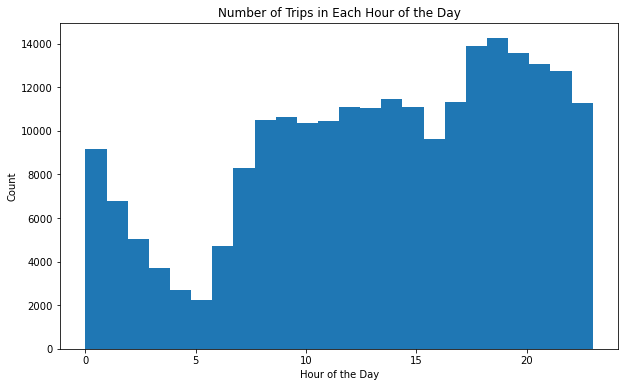

<Figure size 432x288 with 0 Axes>

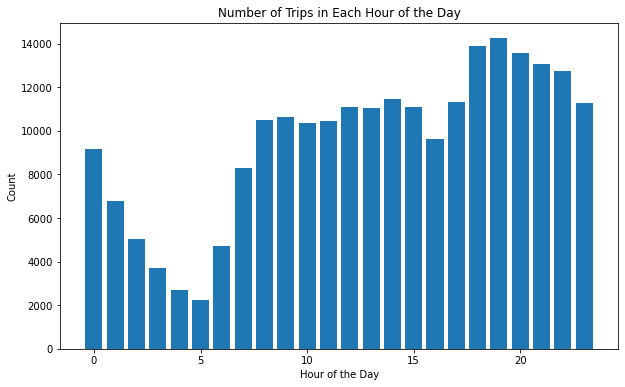

In [173]:
def plot_popular_hour():
    taxi_trips['pickup_datetime']= pd.to_datetime(taxi_trips['pickup_datetime'])
    taxi_trimmed = taxi_trips[(taxi_trips.pickup_datetime>='2009-01-01') & (taxi_trips.pickup_datetime<"2015-07-01")]
    taxi_trimmed['hour'] = taxi_trimmed['pickup_datetime'].dt.hour

    #histogram
    f2=plt.figure(2)
    fig, ax = plt.subplots(figsize=(10, 6))
    a= taxi_trimmed['hour'].array
    plt.hist(a,bins=24);
    plt.xlabel('Hour of the Day')
    plt.ylabel('Count')
    plt.title('Number of Trips in Each Hour of the Day')
    
    #bar chart
    f1=plt.figure(1)
    fig, ax = plt.subplots(figsize=(10, 6))
    x = taxi_trimmed.groupby('hour')['hour'].count().index
    y = taxi_trimmed.groupby('hour')['hour'].count()
    plt.bar(x,y);
    plt.xlabel('Hour of the Day')
    plt.ylabel('Count')
    plt.title('Number of Trips in Each Hour of the Day')
    plt.show()
    
plot_popular_hour()

In [197]:
# taxi_trips['pickup_datetime']= pd.to_datetime(taxi_trips['pickup_datetime'])
# taxi_trimmed = taxi_trips[(taxi_trips.pickup_datetime>='2009-01-01') & (taxi_trips.pickup_datetime<"2015-07-01")]
# taxi_trimmed['hour'] = taxi_trimmed['pickup_datetime'].dt.hour
# taxi_trimmed.groupby('hour')['hour'].count()

#### 2. Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month) for both taxis and Ubers combined. Include the 90% confidence interval around the mean in the visualization.
Answer:

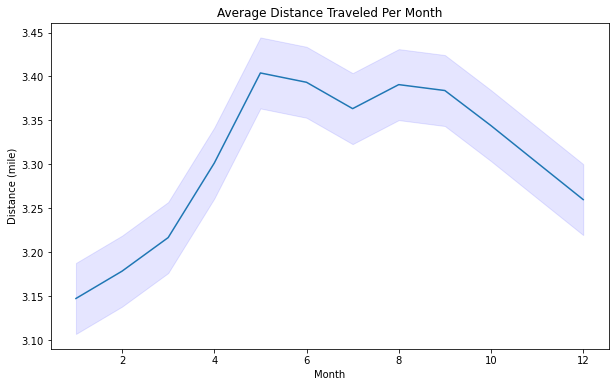

In [181]:
def avg_distance_month():
    #retrieve the month from datetime
    taxi_trips['pickup_datetime']= pd.to_datetime(taxi_trips['pickup_datetime'])
    taxi_trips_1 = taxi_trips.loc[:,['pickup_datetime','distance']]
    taxi_trips_1['month'] = taxi_trips_1['pickup_datetime'].dt.month
    taxi_trips_1
    uber_trips['pickup_datetime']= pd.to_datetime(uber_trips['pickup_datetime'])
    uber_trips_1 = uber_trips.loc[:,['pickup_datetime','distance']]
    uber_trips_1['month'] = uber_trips_1['pickup_datetime'].dt.month
    uber_trips_1
    
    #combine two df and groupby month & take mean
    comb = uber_trips_1.append(taxi_trips_1)
    ay = comb.groupby('month').mean()
    ay.reset_index(inplace=True)

    #plot
    x=ay['month']
    y=ay['distance']
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(x,y, '-')
    
    #define 90% confidence interval
    ci = 1.645 * np.std(y)/np.sqrt(len(ay))
    plt.fill_between(x, (y-ci), (y+ci), color='blue', alpha=0.1)
    plt.xlabel('Month')
    plt.ylabel('Distance (mile)')
    plt.title('Average Distance Traveled Per Month')
    
avg_distance_month()


3. Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares what day of the week was most popular for drop offs for each airport.


4. Create a heatmap of all hired trips over a map of the area. Consider using KeplerGL or another library that helps generate geospatial visualizations.

#### 5. Create a scatter plot that compares tip amount versus distance for Yellow Taxi rides. You may remove any outliers how you see fit.
Answer:

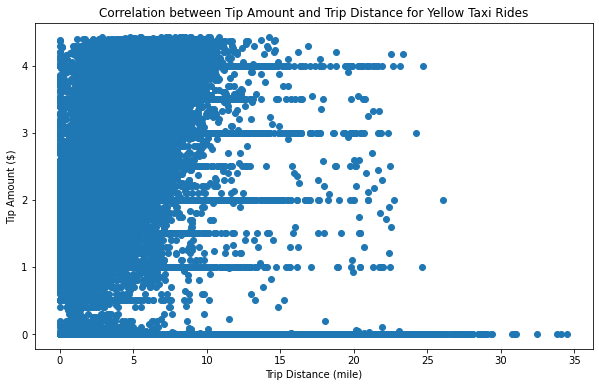

In [186]:
def corr_tip_distance():
    #trim df to two columns
    taxi_trips_1 = taxi_trips.loc[:,['tip_amount', 'distance']]
    #determine outliers
    dataset = taxi_trips_1['tip_amount']
    sorted(dataset)
    q1, q3= np.percentile(dataset,[25,75])
    iqr = q3 - q1
    lower_bound = q1 -(1.5 * iqr) 
    upper_bound = q3 +(1.5 * iqr)
    #remove outliers 
    taxi_trips_2 = taxi_trips_1[taxi_trips_1['tip_amount']<=upper_bound]
    x=taxi_trips_2['distance']
    y=taxi_trips_2['tip_amount']
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.scatter(x, y, marker='o')
    plt.xlabel('Trip Distance (mile)')
    plt.ylabel('Tip Amount ($)')
    plt.title('Correlation between Tip Amount and Trip Distance for Yellow Taxi Rides')
    
corr_tip_distance()

In [185]:
taxi_trips

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,distance
0,0,1,2015-01-24 14:58:38,2015-01-24 15:02:19,1,-73.956810,40.781162,-73.955429,40.773361,1,5.0,0.0,0.5,1.15,0.0,6.95,0.875471
1,1,1,2015-01-08 15:39:52,2015-01-08 15:44:22,1,-73.975601,40.752163,-73.981140,40.744507,2,4.5,0.0,0.5,0.00,0.0,5.30,0.971107
2,2,2,2015-01-07 15:21:40,2015-01-07 15:29:07,1,-73.952255,40.777321,-73.959785,40.766941,2,6.5,0.0,0.5,0.00,0.0,7.30,1.317316
3,3,2,2015-01-10 18:19:43,2015-01-10 18:26:58,1,-73.995934,40.732300,-73.997925,40.736084,2,6.0,0.0,0.5,0.00,0.0,6.80,0.453140
4,4,2,2015-01-24 12:16:16,2015-01-24 12:30:55,5,-73.978249,40.752361,-74.005623,40.715229,2,13.5,0.0,0.5,0.00,0.0,14.30,4.730957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246478,251995,CMT,2009-12-13 09:12:35,2009-12-13 09:14:35,1,-73.990913,40.670626,-73.991142,40.669925,Cash,3.7,0.0,0.5,0.00,0.0,4.20,0.080330
246479,251996,VTS,2009-12-24 14:19:00,2009-12-24 14:37:00,2,-73.975545,40.728643,-73.951623,40.783325,CASH,13.7,0.0,0.5,0.00,0.0,14.20,6.407539
246480,251997,CMT,2009-12-27 21:03:51,2009-12-27 21:22:37,1,-73.999803,40.726753,-73.993088,40.665041,Cash,19.7,0.5,0.5,0.00,0.0,20.70,6.887535
246481,251998,CMT,2009-12-12 20:25:55,2009-12-12 20:41:44,3,-73.997882,40.751496,-73.993273,40.722716,Cash,10.5,0.5,0.5,0.00,0.0,11.50,3.224676


In [196]:
sum(hourly_weather['HourlyPrecipitation'].notna())
sum(daily_weather['DailyPrecipitation'].notna())


1249

In [195]:
daily_weather

,id,DATE,DailyAverageWindSpeed,DailyPeakWindSpeed,DailyPrecipitation,DailySustainedWindSpeed
0,0,2012-01-01T00:51:00,NaN,NaN,None,NaN
1,1,2012-01-01T01:51:00,NaN,NaN,None,NaN
2,2,2012-01-01T02:51:00,NaN,NaN,None,NaN
3,3,2012-01-01T03:51:00,NaN,NaN,None,NaN
4,4,2012-01-01T04:51:00,NaN,NaN,None,NaN
...,...,...,...,...,...,...
77967,77967,2010-12-31T19:51:00,NaN,NaN,None,NaN
77968,77968,2010-12-31T20:51:00,NaN,NaN,None,NaN
77969,77969,2010-12-31T21:51:00,NaN,NaN,None,NaN
77970,77970,2010-12-31T22:51:00,NaN,NaN,None,NaN


#### 6. Create another scatter plot that compares tip amount versus precipitation amount for Yellow Taxi rides. You may remove any outliers how you see fit.
Answer:

In [182]:
def corr_tip_percip():
    #trim df to two columns
    taxi_trips_1 = taxi_trips.loc[:,['tip_amount', 'distance']]
    #determine outliers
    dataset = taxi_trips_1['tip_amount']
    sorted(dataset)
    q1, q3= np.percentile(dataset,[25,75])
    iqr = q3 - q1
    lower_bound = q1 -(1.5 * iqr) 
    upper_bound = q3 +(1.5 * iqr)
    #remove outliers 
    taxi_trips_2 = taxi_trips_1[taxi_trips_1['tip_amount']<upper_bound]
    x=taxi_trips_2['distance']
    y=taxi_trips_2['tip_amount']
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.scatter(x, y, marker='o')
    plt.xlabel('Trip Distance (mile)')
    plt.ylabel('Tip Amount ($)')
    plt.title('Correlation between Tip Amount and Trip Distance for Yellow Taxi Rides')
    
corr_tip_distance()

,tip_amount,distance
0,1.15,0.875471
1,0.00,0.971107
2,0.00,1.317316
3,0.00,0.453140
4,0.00,4.730957
...,...,...
246478,0.00,0.080330
246479,0.00,6.407539
246480,0.00,6.887535
246481,0.00,3.224676


7. Come up with 3 questions on your own that can be answered based on the data in the 4 tables. Create at least one visualization to answer each question. At least one visualization should require data from at least 3 tables.

7-1. 

7-2.

7-3.